# Install Libraries

In [1]:
%pip install numpy
%pip install pandas
%pip install openpyxl
%pip install matplotlib
%pip install statsmodels
%pip install sklearn
%pip install prophet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requiremen

In [2]:
import os
import argparse
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from prophet import Prophet

/Users/michaelmallamaci/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


# Input Arguments

In [3]:
EXCEL_FILE_PATH = 'CBO Revenue Short.xlsx'
OUTPUT_FILE_PATH = 'TruCast Output 3 Month.xlsx'
MEDIUM_THRESHOLD = 200000 # in dollars
LARGE_THRESHOLD = 533000 # in dollars
NUMBER_OF_MONTHS = 12 # in months

# Functions

In [15]:
def three_month(revenue_series):
    three_month_proj = pd.Series([revenue_series.iloc[-3], revenue_series.iloc[-2], revenue_series.iloc[-1]])
    for i in range(3, NUMBER_OF_MONTHS+3):
        number_of_non_nan_points = three_month_proj[i-3:].count()
        temp_series = three_month_proj.fillna(0)
        next_month = (temp_series.iloc[-3] + temp_series.iloc[-2] + temp_series.iloc[-1]) / number_of_non_nan_points
        three_month_proj = pd.concat([three_month_proj, pd.Series([next_month])], ignore_index=True)
    
    three_month_proj = three_month_proj[3:]
    return three_month_proj

In [16]:
series = pd.Series([100, 200, 300])
projected = three_month(series)
print(projected)

3     200.000000
4     233.333333
5     244.444444
6     225.925926
7     234.567901
8     234.979424
9     231.824417
10    233.790581
11    233.531474
12    233.048824
13    233.456959
14    233.345752
dtype: float64


In [17]:
series = pd.Series([100, np.nan, 200])
projected = three_month(series)
print(projected)

3     150.000000
4     175.000000
5     175.000000
6     166.666667
7     172.222222
8     171.296296
9     170.061728
10    171.193416
11    170.850480
12    170.701875
13    170.915257
14    170.822537
dtype: float64


In [18]:
series = pd.Series([np.nan, 100, 200])
projected = three_month(series)
print(projected)

3     150.000000
4     150.000000
5     166.666667
6     155.555556
7     157.407407
8     159.876543
9     157.613169
10    158.299040
11    158.596251
12    158.169486
13    158.354926
14    158.373554
dtype: float64


In [19]:
series = pd.Series([np.nan, np.nan, 200])
projected = three_month(series)
print(projected)

3     200.0
4     200.0
5     200.0
6     200.0
7     200.0
8     200.0
9     200.0
10    200.0
11    200.0
12    200.0
13    200.0
14    200.0
dtype: float64


In [4]:
def fixed(revenue_series):
    return [revenue_series.iloc[-1]]*NUMBER_OF_MONTHS

def three_month(revenue_series):
    three_month_proj = pd.Series([revenue_series.iloc[-3], revenue_series.iloc[-2], revenue_series.iloc[-1]])
    for i in range(3, NUMBER_OF_MONTHS+3):
        number_of_non_nan_points = three_month_proj[i-3:].count()
        temp_series = three_month_proj.fillna(0)
        next_month = (temp_series.iloc[-3] + temp_series.iloc[-2] + temp_series.iloc[-1]) / number_of_non_nan_points
        three_month_proj = pd.concat([three_month_proj, pd.Series([next_month])], ignore_index=True)
    
    three_month_proj = three_month_proj[3:]
    return three_month_proj


def ARIMA_rolling_forcast_origin(revenue_series, number_of_predicted_months, p, q, d):
    # Preforms a rolling forcast origin for an using an arima model on times series data for a set number of number_of_predicted_months < len(revenue_series) 
    arima_revenue_projection_list = revenue_series.tolist()
    total_revenue_by_month_list = revenue_series.tolist()
    for index, revenue in enumerate(arima_revenue_projection_list):
        if len(arima_revenue_projection_list) - index < number_of_predicted_months:
            try:
                model = ARIMA(total_revenue_by_month_list[0:index], order=(p, d, q))
                try:
                    results = model.fit()
                    forecast = results.forecast(steps=1)
                except LinAlgError as e:
                    forecast = [-10000000]
                arima_revenue_projection_list[index] = forecast[0]
            except LinAlgError as e:
                arima_revenue_projection_list[index] = np.nan
                continue
    arima_revenue_projection = pd.Series(data=arima_revenue_projection_list, index=revenue_series.index)
    
    return arima_revenue_projection

def arima(revenue_series):
    # Train on 1/3 of the data
    number_of_predicted_months = int(len(revenue_series)/3)

    # Choose the range of p and q that you want to optmize over
    p_range = 6
    q_range = 6
    d = 1

    # Create an ARIMA model on the data for each value of p and q forcast it forward using a rolling origin forcast, determine which pair of p and q works
    # best and output that
    arima_revenue_projection_list = revenue_series.tolist()
    projection_percent_difference = {}
    for i in range(1, p_range):
        for ii in range(1, q_range):
            projection = ARIMA_rolling_forcast_origin(revenue_series, number_of_predicted_months, i, ii, d)

            percent_difference = abs(projection[-number_of_predicted_months:] - arima_revenue_projection_list[-number_of_predicted_months:]) / arima_revenue_projection_list[-number_of_predicted_months:] * 100
            projection_avg_percent_difference = percent_difference.mean()

            if projection_avg_percent_difference == np.nan:
                # If any errors occur set the percent error to really high so it doesn't get choosen
                projection_percent_difference[(i, ii)] = 1000
            else:
                projection_percent_difference[(i, ii)] = projection_avg_percent_difference

    min_error_key = min(projection_percent_difference, key=projection_percent_difference.get)
    p = min_error_key[0]
    q = min_error_key[1]

    # Use the ARIMA model that produced the minimum error and forcast 1 time step forward
    model = ARIMA(revenue_series, order=(p, d, q))
    results = model.fit()
    forecast = results.forecast(steps=NUMBER_OF_MONTHS)

    return forecast

def prophet(revenue_series):
    # for the model, make a dataframe with columns 'ds' and 'y' out of the hospital row, which was a Series
    curr_hospital = pd.DataFrame({'ds':revenue_series.index, 'y':revenue_series.values})

    # make the months datetime objects, and the revenues numbers
    curr_hospital['ds'] = pd.to_datetime(curr_hospital['ds'])
    curr_hospital['y'] = pd.to_numeric(curr_hospital['y'])

    # training on all revenues up to the last year (CAN BE MODIFIED TO BE THE LAST MONTH, TWO MONTHS, ETC.)
    # MUDIT COMMENT: JUST GOT RID OF THE "-NUMBER_OF_MONTHS" HERE, NOW TRAINING ON ALL DATA IN REVENUE_SERIES
    train = curr_hospital.iloc[:len(curr_hospital)]

    # testing how accurately we predict the last year (CAN BE MODIFIED TO BE THE LAST MONTH, TWO MONTHS, ETC.)
    test = curr_hospital.iloc[len(curr_hospital) - NUMBER_OF_MONTHS:]

    # if this row of the dataframe contains less than two non-nan values, we cannot predict on it — SKIP
    if train[train['y'].notnull()].shape[0] < 2:
        return None # WE SHOULD REDIRECT HERE TO ANOTHER MODEL, IF THERE IS NOT ENOUGH TRAINING DATA FOR PROPHET
    
    # fit the model, generate the forecast
    m = Prophet()
    m.fit(train)
    future = m.make_future_dataframe(periods = NUMBER_OF_MONTHS, freq='MS')
    forecast = m.predict(future)

    # generate predictions (contains all from 2004 through 2023)
    predictions = forecast[['ds', 'yhat']].set_index('ds')['yhat'].iloc[-NUMBER_OF_MONTHS:]
    predictions_lower = forecast[['ds', 'yhat_lower']].set_index('ds')['yhat_lower'].iloc[-NUMBER_OF_MONTHS:]
    predictions_upper = forecast[['ds', 'yhat_upper']].set_index('ds')['yhat_upper'].iloc[-NUMBER_OF_MONTHS:]
    
    output_columns = predictions.index

    # return a tuple of the lower, point estimate, and upper bound for the last month
    return (predictions.values, predictions_lower.values, predictions_upper.values)
    
def determine_projection_type(revenue_series, medium_threshold, large_threshold):
    THREE_MONTH_AVERAGE_DATA_CUTOFF = 6

    if (revenue_series.iloc[-2] == revenue_series.iloc[-1]) or (np.isnan(revenue_series.iloc[-1])):
        return 'fixed'
    elif revenue_series.iloc[-NUMBER_OF_MONTHS:].count() >= THREE_MONTH_AVERAGE_DATA_CUTOFF:
        # if there are less than 12 but more than 6 monthds of data, then find yearly revenue
        number_of_month_data_points = revenue_series.iloc[-NUMBER_OF_MONTHS:].count()
        yearly_revenue = (sum(revenue_series.iloc[-number_of_month_data_points:])/number_of_month_data_points)*12
    else:
        # if there isn't a years worth of data just return a 3 month average
        return 'three_month'
    
    if yearly_revenue < medium_threshold:
        return 'arima'
    else:
        return 'prophet'
    
def rename_duplicates(names):
    name_count = {}
    modified_names = []

    for name in names:
        if name in name_count:
            name_count[name] += 1
        else:
            name_count[name] = 1

        if name_count[name] == 1:
            modified_names.append(name)
        else:
            modified_names.append(f"{name}_{name_count[name]-1}")

    return modified_names
    


# TruCast

In [5]:
def process(input_path, export_path):
    if input_path.endswith('.xls') or input_path.endswith('.xlsx'):
        #revenue_data = pd.read_excel(EXCEL_FILE_PATH, index_col=['Site', 'Customer Code'])
        revenue_data = pd.read_excel(input_path, index_col='site')
    else:
        print("Error: Input file must be in Excel format.")

    # TODO Clean data


    # Create dataframe for the output date
    new_months = list(pd.date_range(revenue_data.columns[-1], periods=13, freq='M').strftime('%Y-%m'))[1:13]
    revenue_data.columns = [col.strftime('%Y-%m') if isinstance(col, pd.Timestamp) else col for col in revenue_data.columns]
    column_names = list(revenue_data.columns) + new_months
    revenue_data.index = rename_duplicates(revenue_data.index)
    output_data = pd.DataFrame(index=revenue_data.index, columns=column_names)

    #Loop through hospitals
    for hospital, revenue_series in revenue_data.iterrows():
        projection_type = determine_projection_type(revenue_series, MEDIUM_THRESHOLD, LARGE_THRESHOLD)
        print(f'{hospital}: {projection_type}')
        if projection_type == 'fixed':
            projection = fixed(revenue_series)
        elif projection_type == 'three_month':
            projection = three_month(revenue_series)
        elif projection_type == 'arima':
            projection = arima(revenue_series)
            #projection = [0]*12
        elif projection_type == 'prophet':
            (projection, prophet_low, prophet_high) = prophet(revenue_series)

        projection = [rev if rev >= 0 or np.isnan(rev) else 0 for rev in projection] # Sets a lower bound of 0 for any projection

        output_data.loc[hospital] = pd.concat([revenue_series, pd.Series(data=projection, index=new_months)])

    output_data.dropna(inplace=True, how='all')
    output_data.to_excel(export_path, index_label='site')
    display(output_data)
    return output_data

output_data = process(EXCEL_FILE_PATH, OUTPUT_FILE_PATH)

/var/folders/9p/z0q47mr505g16yjy21l4hmj80000gn/T/ipykernel_58505/2188530388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  new_months = list(pd.date_range(revenue_data.columns[-1], periods=13, freq='M').strftime('%Y-%m'))[1:13]
15:56:54 - cmdstanpy - INFO - Chain [1] start processing
15:56:54 - cmdstanpy - INFO - Chain [1] done processing


Abraham Lincoln: fixed
Acadia-St.Landry Hospital: prophet
Adirondack Medical Center: fixed
Alaska Native Tribal Health: three_month
Aleutian Pribilof Islands Association: arima


/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA a

Escambia County: arima


/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

Wyckoff Heights: arima


/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/anshviswanathan/.pyenv/versions/3.11.9/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retval

Escambia County_1: prophet


,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,...,2024-03,2024-04,2024-05,2024-06,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12
Abraham Lincoln,16865.0,18965.0,22201.0,27864.0,20430.0,25328.0,20897.0,17417.0,53978.0,31801.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
Acadia-St.Landry Hospital,47335.0,47151.0,71127.0,55330.0,53569.0,90612.0,50765.0,53116.0,48687.0,32288.0,...,56049.557417,33564.54127,13071.931893,70506.064652,31413.138244,34146.006684,49494.90961,12069.627693,31519.652271,36652.051866
Adirondack Medical Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alaska Native Tribal Health,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0,3826.0
Aleutian Pribilof Islands Association,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10647.068878,10647.199509,10647.190655,10647.191255,10647.191214,10647.191217,10647.191217,10647.191217,10647.191217,10647.191217
Escambia County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67861.0,88438.0,...,7020.756201,7019.672405,7019.497308,7019.46902,7019.46445,7019.463711,7019.463592,7019.463573,7019.46357,7019.463569
Wyckoff Heights,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17512.271689,7566.827625,14471.764094,7566.827627,14471.764092,7566.82763,14471.76409,7566.827632,14471.764087,7566.827634
Escambia County_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67861.0,88438.0,...,101284.081076,111407.394308,62851.438745,135318.887786,69353.969049,102101.635754,77322.4415,105045.845708,96457.655972,137204.645673


# Plot the Data

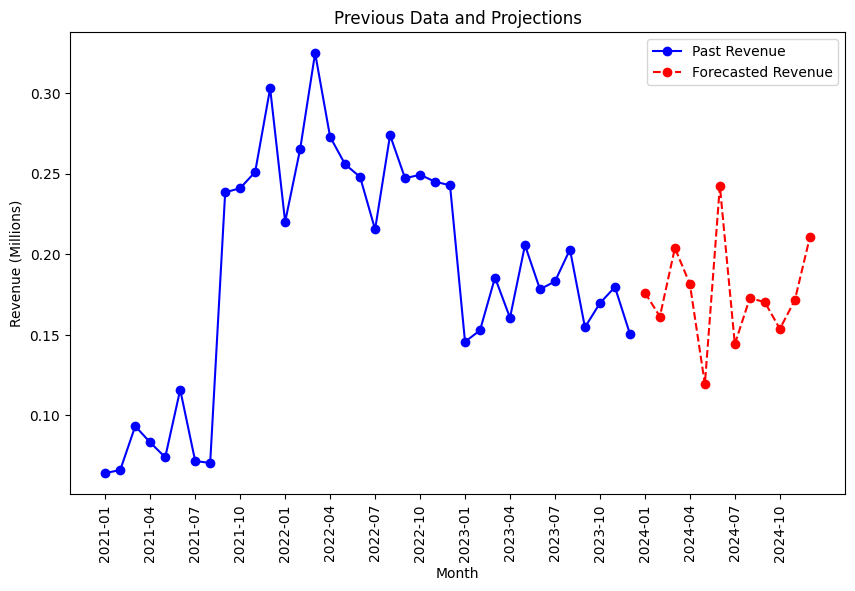

In [6]:
plt.figure(figsize=(10, 6))

# Adjust the data by dividing by 1 million to convert to millions
past_revenue = output_data.sum().values[0:-NUMBER_OF_MONTHS] / 1e6
forecasted_revenue = output_data.sum().values[-NUMBER_OF_MONTHS:] / 1e6

# Plotting the past revenue
plt.plot(output_data.columns[0:-NUMBER_OF_MONTHS], past_revenue, color='blue', marker='o', linestyle='-', label='Past Revenue')
# Plotting the forecasted revenue
plt.plot(output_data.columns[-NUMBER_OF_MONTHS:], forecasted_revenue, color='red', marker='o', linestyle='--', label='Forecasted Revenue')

plt.title('Previous Data and Projections')
plt.xlabel('Month')
plt.ylabel('Revenue (Millions)')
plt.xticks(output_data.columns[0::3], rotation=90)  # Adjust x-axis ticks

# Adding the legend to the plot
plt.legend()

# Show the plot
plt.show()

# Find Residuals